In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_dataset = tf.data.Dataset.from_generator(lambda: train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
train_dataset = train_dataset.repeat()


validation_dataset = tf.data.Dataset.from_generator(lambda: validation,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
validation_dataset = validation_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
test_dataset = test_dataset.repeat()

In [5]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [6]:
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

In [7]:
from keras.applications import InceptionV3

inception_base_model = InceptionV3(input_shape=(180,180,3),include_top=False,weights='imagenet')

In [8]:
    inception_model = Sequential([
        inception_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    inception_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [9]:
r = inception_model.fit( train_dataset ,
          epochs=30,
          validation_data=validation_dataset,
          class_weight=class_weight,
          steps_per_epoch=250,
          validation_steps=52)


Epoch 1/30
250/250 [==============================] - 392s 1s/step - loss: 0.3312 - accuracy: 0.5555 - precision: 0.8036 - recall: 0.5412 - val_loss: 189.6697 - val_accuracy: 0.5192 - val_precision: 0.4898 - val_recall: 1.0000
Epoch 2/30
250/250 [==============================] - 376s 2s/step - loss: 0.2574 - accuracy: 0.6675 - precision: 0.8584 - recall: 0.6521 - val_loss: 12.9767 - val_accuracy: 0.5385 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
250/250 [==============================] - 334s 1s/step - loss: 0.2044 - accuracy: 0.7315 - precision: 0.9170 - recall: 0.7062 - val_loss: 0.8799 - val_accuracy: 0.5769 - val_precision: 0.5625 - val_recall: 0.9643
Epoch 4/30
250/250 [==============================] - 328s 1s/step - loss: 0.1798 - accuracy: 0.7910 - precision: 0.9282 - recall: 0.7777 - val_loss: 0.9848 - val_accuracy: 0.5577 - val_precision: 0.6471 - val_recall: 0.3929
Epoch 5/30
250/250 [==============================] - 338s 1s/step - loss: 0.1649 - accur

Text(0.5, 1.0, 'Accuracy Evolution')

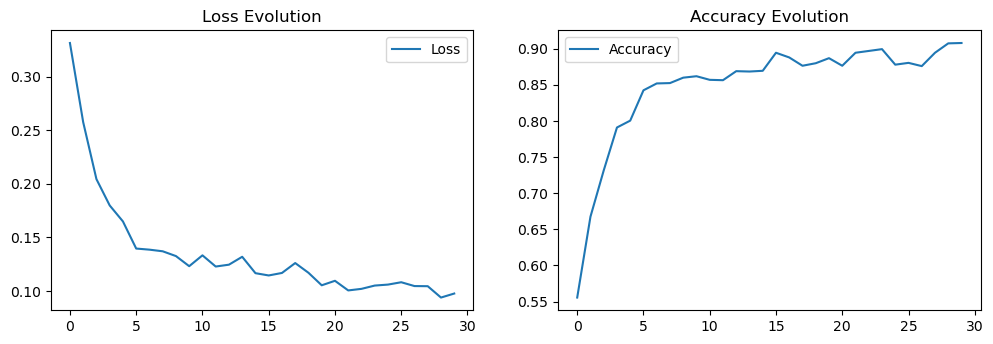

In [10]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [11]:
evaluation =inception_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = inception_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 61s 92ms/step - loss: 1.0070 - accuracy: 0.7532 - precision: 0.7296 - recall: 0.9615
Test Accuracy: 75.32%
652/652 [==============================] - 255s 391ms/step - loss: 0.3457 - accuracy: 0.9241 - precision: 0.9387 - recall: 0.9605
Train Accuracy: 92.41%


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pred = inception_model.predict(test)

conf_mat = confusion_matrix(test.classes, pred > 0.5)
print(conf_mat)

class_report = classification_report(test.classes, pred > 0.5, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)


624/624 [==============================] - 56s 85ms/step
[[175  59]
 [ 37 353]]
              precision    recall  f1-score     support
0              0.825472  0.747863  0.784753  234.000000
1              0.856796  0.905128  0.880299  390.000000
accuracy       0.846154  0.846154  0.846154    0.846154
macro avg      0.841134  0.826496  0.832526  624.000000
weighted avg   0.845049  0.846154  0.844470  624.000000


In [13]:
inception_model.save('my_model_gn.h5')
print("done")

done


In [ ]:
#75.96/80.41
#74.36/85.20
#86.70/88.82
#84.46/88.31